In [13]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..), v(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02f0
r2 = 1

eqs = [Dt(u(t, x)) ~ r2 * Dxx(u(t, x))*(3abs2(u(t, x)) - 1) + 6*(abs2(Dx(u(t, x))))*u(t, x) - r1 * Dxx(v(t,x)),
       v(t, x) ~ Dxx(u(t,x))]

bcs = [u(0, x) ~ cospi(x)-exp(-4*1f0π*1f0π*abs2(x)),
    u(t, -1) ~ u(t, 1),
    Dx(u(t, -1)) ~ Dx(u(t, 1))]

domains = [t ∈ Interval(0, 1),
           x ∈ Interval(-1, 1)]

@named pde_system = PDESystem(eqs, bcs, domains, [t,x], [u(t,x), v(t,x)])

In [4]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5) |> gpu
pinn = PINN(u=chain, v=chain)
sampler = BetaRandomSampler(1000, (400, 100, 100))
strategy = NonAdaptiveTraining(1, (500,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy) 

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(u = (layer_1 = (weight = [0.12998513877391815 1.2746551036834717; -1.3218175172805786 -1.997926115989685; … ; 1.9581668376922607 -0.07053744792938232; 0.3603510558605194 -0.24344687163829803], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.046862345188856125 -0.6094663143157959 … 0.020102297887206078 -0.3357929587364197; 0.47430792450904846 0.39020779728889465 … -0.30497977137565613 -0.46445271372795105; … ; -0.07769995927810669 -0.14656685292720795 … 0.11073439568281174 0.2695309519767761; 0.23342663049697876 -0.012522458098828793 … -0.6436522006988525 0.26910120248794556], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.4394490718841553 0.20065957307815552 … -0.2265426069498062 0.007383342832326889; -0.5700663924217224 0.6767510175704956 … -0.004110431764274836 0.14770539104938507; … ; 0.6167199611663818 0.6401734352111816 … 0.3099207580089569 -0.6415146589279175; -0.5676432847976685 0.10554727911

In [8]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

@time res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 17.28652606491209


Loss: 4.885388142839301


Loss: 1.6897951554813306


Loss: 0.6914381712478376


Loss: 0.1902632020035641


Loss: 0.0771250207720467


Loss: 0.034312104188974575


Loss: 0.016077893015459782


Loss: 0.008864841033447009


Loss: 0.004887736214703672


Loss: 0.0027517011938862543
162.912048 seconds (34.26 M allocations: 285.837 GiB, 5.15% gc time)


u: ComponentVector{Float64}(u = (layer_1 = (weight = [0.5420763079672053 1.5885239696063689; -1.6825626071461948 -1.3868380602211148; … ; 4.175878691847262 -0.061273445525472724; 0.8581753137046658 0.27961298422617237], bias = [1.6343956908766741; -0.24232367305141347; … ; 0.07054315283569662; 0.15203285249838655;;]), layer_2 = (weight = [-0.06678877785693756 -0.4387308740415681 … 0.03200306317799036 -0.35425294366345617; 0.6543762811982065 -0.18026303385342157 … -1.486207841897817 -0.8806437336836448; … ; 0.11312160020534295 -0.37404052066461857 … 0.6352558977552184 0.45480168615485; -0.07747858087630959 -0.21347714077571806 … -1.7822152254281611 0.005344471936205424], bias = [0.27221182178853454; -1.073168211158468; … ; 0.1700905323267823; 0.09967147768918319;;]), layer_3 = (weight = [0.11523416569269118 0.07015193892074054 … 0.18178282338368207 -0.22101450217230337; -0.7810886813106618 0.549272529141959 … 0.18153050680764163 -0.4784802991353265; … ; 0.10570107906639718 0.81556229820

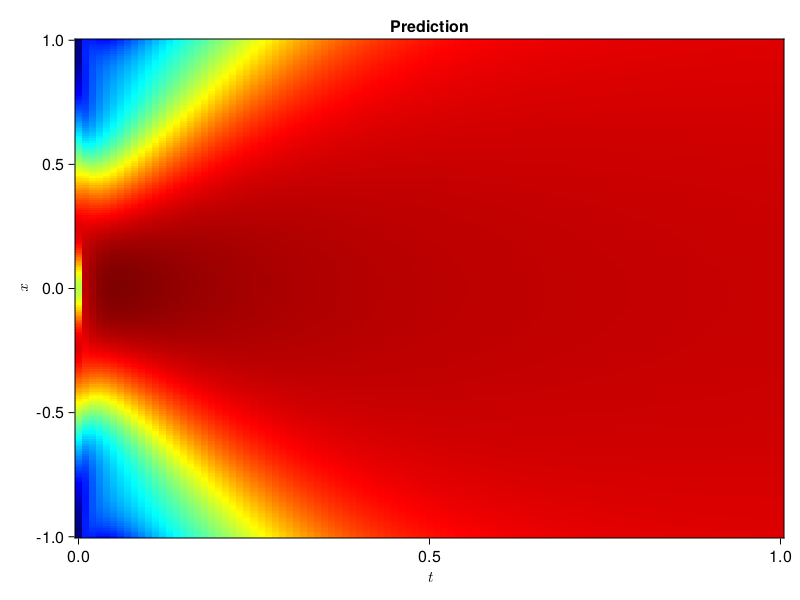

In [11]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi.u([t, x], res.u.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

Loss: 2815.9527397194697


Loss: 12.962939726168244


Loss: 4.432419106197773


Loss: 2.4800533550228914


Loss: 1.5624269738173424


Loss: 1.1974038748073885


Loss: 0.8467548980992304


Loss: 0.6102966463685884


Loss: 0.35912226273912173


Loss: 0.22488204799568765


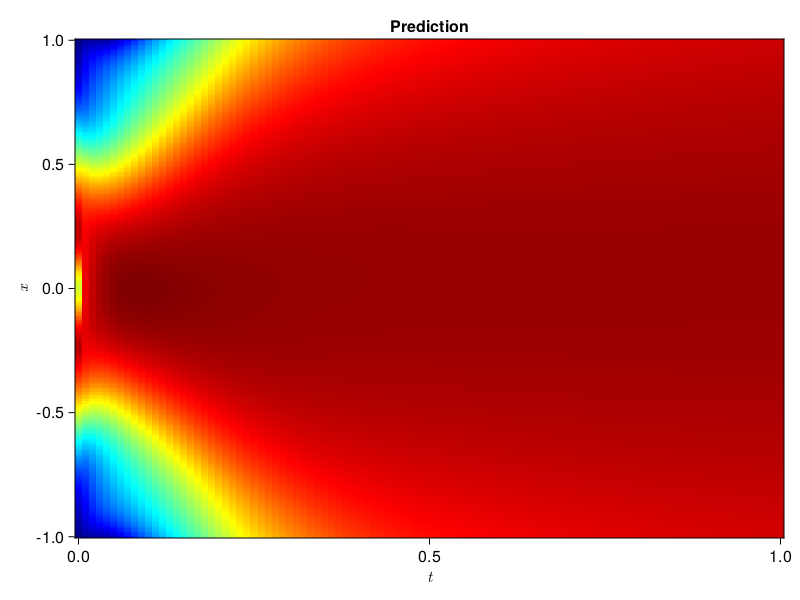

Loss: 0.14978338918533238


Loss: 2.350912919727786


Loss: 0.05396802258268262


Loss: 0.01998531496330272


Loss: 0.009403123499032351


Loss: 0.0055861508553529645


Loss: 0.003302081291533036


Loss: 0.002001241514030309


Loss: 0.0013638316087206954


Loss: 0.0010316384977709973


Loss: 0.0007929557859118351


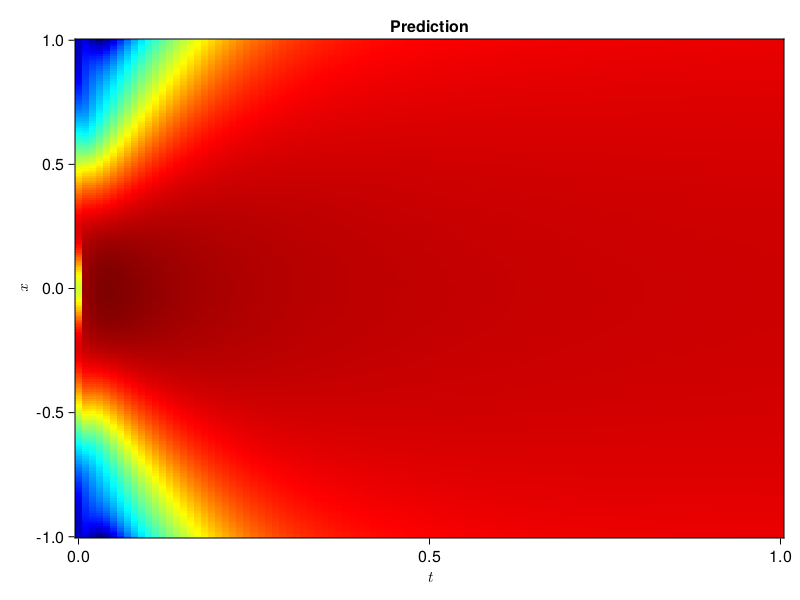

Loss: 0.000655531013456932


Loss: 4.876606243749839


Loss: 0.02324648576939922


Loss: 0.002070435709476361


Loss: 0.0006743132219400061


Loss: 0.00038040867290618113


Loss: 0.00021331346231644256


Loss: 0.00012151815318987411


Loss: 7.848091536793509e-5


Loss: 5.266013758783087e-5


Loss: 3.8824798852628714e-5


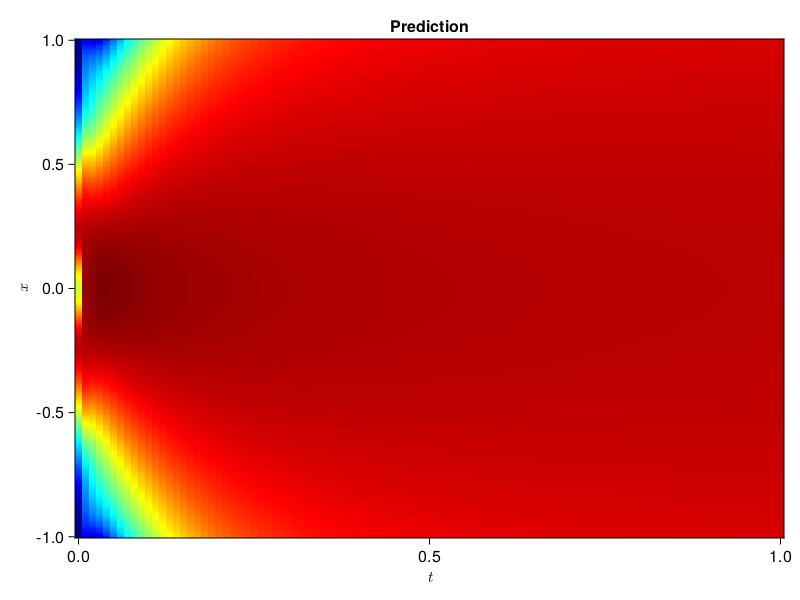

Loss: 3.23000350230067e-5


In [12]:
for α in [0.6, 0.8, 1.0] 
    i = 0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi.u([t, x], res.u.u)) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end